# Ejercicio 1 - Análisis descriptivo

Responder a la pregunta: **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

Para ello:
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

Si lo consideran necesario, realicen varias iteraciones. Es decir, si encuentran que las distribuciones de los lenguajes de programación que seleccionaron inicialmente no son muy diferentes, pueden re-hacer el análisis usando sólo los lenguajes de programación que son diferentes.

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', 500)


Acá leo el df desde la dirección

In [116]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

Aplico la función para expandir al rows cada lenguaje de programación. Se considera a cada lenguaje de programación que sabe el encuestado como una encuensta en particular. Termino con **df_lang** como dataframe final para empezar los análisis de estadísiticos descriptivos.

In [117]:
def split_languages(languages_str):
    if not isinstance(languages_str, str):
        return []
    languages_str = languages_str.lower().replace('ninguno de los anteriores', '')    
    return [lang.strip().replace(',', '')
        for lang in languages_str.split()]

In [118]:
# Create a new column with the list of languages
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO']

df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages.apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages')

df_lang = df.cured_programming_languages.apply(pd.Series).stack().reset_index(level=-1, drop=True).to_frame().join(df[relevant_columns]).rename(columns={0: 'programming_language'})

In [119]:
df_lang.head()

,programming_language,tools_programming_languages,salary_monthly_NETO,cured_programming_languages
0,ninguno,Ninguno,43000.0,[ninguno]
1,html,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
2,ninguno,Ninguno,127000.0,[ninguno]


Análisis descriptivos sobre la **población general** de programadores. Descarto los sueldos por debajo de **minumum_salary** y por encima de **maximum_salary**

In [139]:
minumum_salary=50000
maximum_salary=1000000

df_filtered = df_lang.loc[(df_lang['salary_monthly_NETO'] > minumum_salary) & (df_lang['salary_monthly_NETO'] < maximum_salary)].sort_values(by='salary_monthly_NETO', ascending=True).reset_index(drop=True)

# Whole population central distibution statistics and overall propabilities

pop_mean = df_filtered['salary_monthly_NETO'].mean()
pop_median = df_filtered['salary_monthly_NETO'].median()
df_greater_pop_mean = df_filtered[df_filtered['salary_monthly_NETO'] > pop_mean]
prob_greater_pop_mean = len(df_greater_pop_mean) / len(df_filtered)

In [140]:
df_filtered.salary_monthly_NETO.max()

964320.0

Acá itero sobre **df_lang** para hacer los análisis sobre las distintas poblaciones de lenguages. Me interesan los lenguages con mas de 100 programadores por condiserarlo que tienen un espacio de muestra para exhibir una conclusión representativa. Se termina con **df_final_metrics** que tiene toda la estadística descriptiva para responder a las preguntas del ejercicio.

In [141]:
# Iteration through dataframe to perform per program analysis

list_of_languages = df_filtered['programming_language'].unique()

df_columns = ['Language','n_programmers','subpop_Salary_mean','subpop_Salary_median','subpop_Central_Diff','within_subpop_>avg','conditional_prob','pop_prob','cond_ratio']
df_final_metrics = pd.DataFrame(columns= df_columns)
data = []

number_of_programmers_cutoff = 100

for item in list_of_languages:
  
    selected_language_dataframe = df_filtered[df_filtered['programming_language'] == item]
    subpop_programmers_number = len(selected_language_dataframe)

    if subpop_programmers_number > number_of_programmers_cutoff:

        subpop_mean = round(selected_language_dataframe['salary_monthly_NETO'].mean(),2)
        subpop_median = round(selected_language_dataframe['salary_monthly_NETO'].median(),2)
        subpop_above_mean_prob = len(selected_language_dataframe[selected_language_dataframe['salary_monthly_NETO'] > subpop_mean]) / len(selected_language_dataframe)
        subpop_central_diff = subpop_mean - subpop_median
        df_within_subpop_above_avg_salary = selected_language_dataframe[selected_language_dataframe['salary_monthly_NETO'] > subpop_mean]
        prob_within_subpop_above_avg_salary = len(df_within_subpop_above_avg_salary) / len(selected_language_dataframe)

        #Conditional probability (in subpop and above pop average)
        df_intersection = df_within_subpop_above_avg_salary[['programming_language', 'salary_monthly_NETO']].merge(df_greater_pop_mean[['programming_language', 'salary_monthly_NETO']]).drop_duplicates()
        try:
            conditional_prob = len(df_intersection) / len(df_within_subpop_above_avg_salary)
        except:
            continue

        subpop_pop_cond_ratio = conditional_prob / prob_greater_pop_mean

        #Construct the df with the metrics of interest
        values = [item,subpop_programmers_number,subpop_mean,subpop_median,subpop_central_diff,round(prob_within_subpop_above_avg_salary,2),round(conditional_prob,2),round(prob_greater_pop_mean,2),round(subpop_pop_cond_ratio,2)]
        zipped = zip(df_columns, values)
        a_dictionary = dict(zipped)
        data.append(a_dictionary)

df_final_metrics = df_final_metrics.append(data, True)
df_final_metrics = df_final_metrics.sort_values('subpop_Salary_mean', ascending=False).reset_index(drop=True)

In [142]:
df_final_metrics.columns

Index(['Language', 'n_programmers', 'subpop_Salary_mean',
       'subpop_Salary_median', 'subpop_Central_Diff', 'within_subpop_>avg',
       'conditional_prob', 'pop_prob', 'cond_ratio'],
      dtype='object')

In [143]:
df_final_metrics.subpop_Salary_mean.describe()

count        20.00000
mean     121933.85000
std       18831.44208
min       93967.03000
25%      110114.99750
50%      119338.23500
75%      126123.24750
max      166230.82000
Name: subpop_Salary_mean, dtype: float64

In [146]:
lenguajes_unique = df_final_metrics.Language.unique()
df_lang_uniques = df_filtered[df_filtered.programming_language.isin(lenguajes_unique)].reset_index(drop=True)
df_lang_uniques

,programming_language,tools_programming_languages,salary_monthly_NETO,cured_programming_languages
0,css,"CSS, HTML, Javascript",50032.00,"[css, html, javascript]"
1,html,"CSS, HTML, Javascript",50032.00,"[css, html, javascript]"
2,javascript,"CSS, HTML, Javascript",50032.00,"[css, html, javascript]"
3,python,Python,50069.76,[python]
4,php,"Bash/Shell, CSS, HTML, Javascript, PHP",50138.00,"[bash/shell, css, html, javascript, php]"
...,...,...,...,...
12638,python,"Bash/Shell, C, Python",952500.00,"[bash/shell, c, python]"
12639,javascript,"Javascript, Python, Scala, TypeScript",964320.00,"[javascript, python, scala, typescript]"
12640,python,"Javascript, Python, Scala, TypeScript",964320.00,"[javascript, python, scala, typescript]"
12641,typescript,"Javascript, Python, Scala, TypeScript",964320.00,"[javascript, python, scala, typescript]"


In [155]:
lang_dict = df_lang_uniques.groupby(['programming_language'], as_index = False).max('salary_monthly_NETO')
lang_dict = lang_dict.set_index('programming_language')['salary_monthly_NETO'].to_dict()
lang_dict

{'.net': 740000.0,
 'bash/shell': 952500.0,
 'c': 952500.0,
 'c#': 740000.0,
 'c++': 800000.0,
 'css': 900000.0,
 'go': 750000.0,
 'groovy': 360000.0,
 'html': 900000.0,
 'java': 836400.0,
 'javascript': 964320.0,
 'kotlin': 535000.0,
 'ninguno': 440000.0,
 'php': 900000.0,
 'python': 964320.0,
 'ruby': 850000.0,
 'scala': 964320.0,
 'sql': 900000.0,
 'typescript': 964320.0,
 'vba': 391000.0}

In [159]:
df_final_metrics['max_salary'] = df_final_metrics.Language.map(lang_dict)
df_final_metrics.sort_values(by=['subpop_Salary_mean'], ascending = True, inplace=True)
df_final_metrics

,Language,n_programmers,subpop_Salary_mean,subpop_Salary_median,subpop_Central_Diff,within_subpop_>avg,conditional_prob,pop_prob,cond_ratio,max_salary
19,vba,159,93967.03,80000.0,13967.03,0.34,0.31,0.29,1.08,391000.0
18,ninguno,248,97560.39,84700.0,12860.39,0.35,0.35,0.29,1.21,440000.0
17,.net,606,108266.98,86000.0,22266.98,0.31,0.32,0.29,1.10,740000.0
16,c#,540,108815.08,85000.0,23815.08,0.29,0.39,0.29,1.33,740000.0
15,sql,1579,108991.52,90000.0,18991.52,0.30,0.28,0.29,0.97,900000.0
14,css,867,110489.49,87000.0,23489.49,0.26,0.41,0.29,1.42,900000.0
13,html,1313,110493.43,86317.0,24176.43,0.27,0.35,0.29,1.20,900000.0
12,java,1137,113783.73,97000.0,16783.73,0.33,0.33,0.29,1.15,836400.0
11,php,626,116371.56,90000.0,26371.56,0.29,0.42,0.29,1.44,900000.0
10,javascript,1825,118985.69,91000.0,27985.69,0.28,0.32,0.29,1.09,964320.0


In [172]:
df_filtered.head()

,programming_language,tools_programming_languages,salary_monthly_NETO,cured_programming_languages
0,css,"CSS, HTML, Javascript",50032.00,"[css, html, javascript]"
1,html,"CSS, HTML, Javascript",50032.00,"[css, html, javascript]"
2,javascript,"CSS, HTML, Javascript",50032.00,"[css, html, javascript]"
3,python,Python,50069.76,[python]
4,php,"Bash/Shell, CSS, HTML, Javascript, PHP",50138.00,"[bash/shell, css, html, javascript, php]"


In [176]:
df_filtered_2 = df_filtered[df_filtered.programming_language.isin(lenguajes_unique)]

In [179]:
df_filtered_2.salary_monthly_NETO.describe()

count     12643.000000
mean     116384.776406
std       88403.848121
min       50032.000000
25%       72000.000000
50%       92000.000000
75%      122000.000000
max      964320.000000
Name: salary_monthly_NETO, dtype: float64

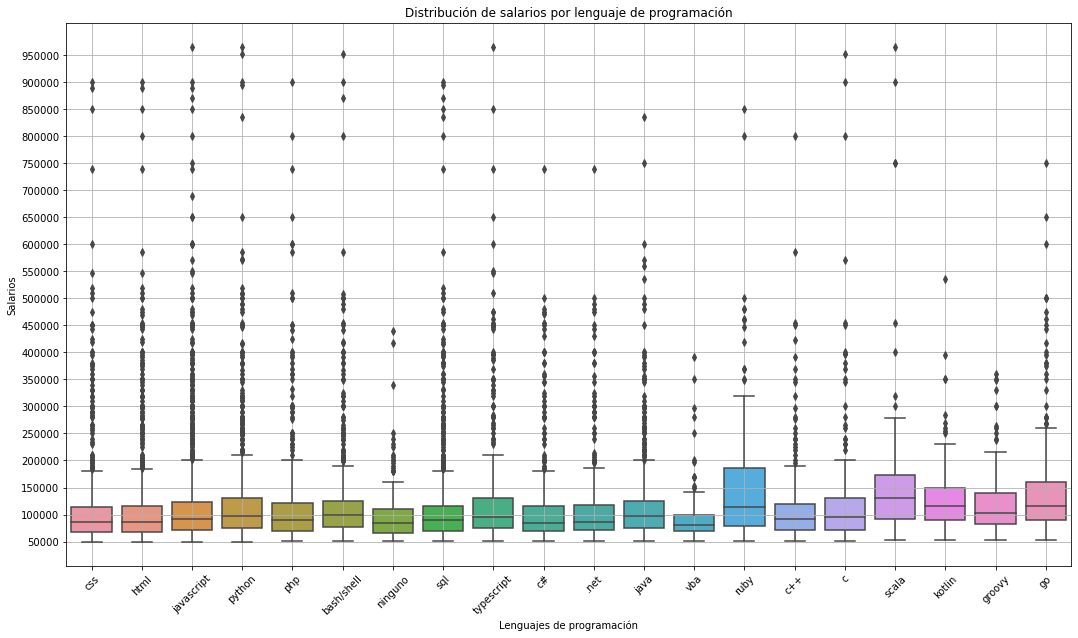

In [189]:
fig = plt.figure(figsize=(18,10))
ax = sns.boxplot(x="programming_language", y="salary_monthly_NETO", data=df_filtered_2)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('Salarios')
plt.xlabel('Lenguajes de programación')
y_min = 50000
y_max = 1000000
ticks = range(y_min, y_max, 50000)
plt.yticks(ticks)
plt.title('Distribución de salarios por lenguaje de programación')
plt.grid()

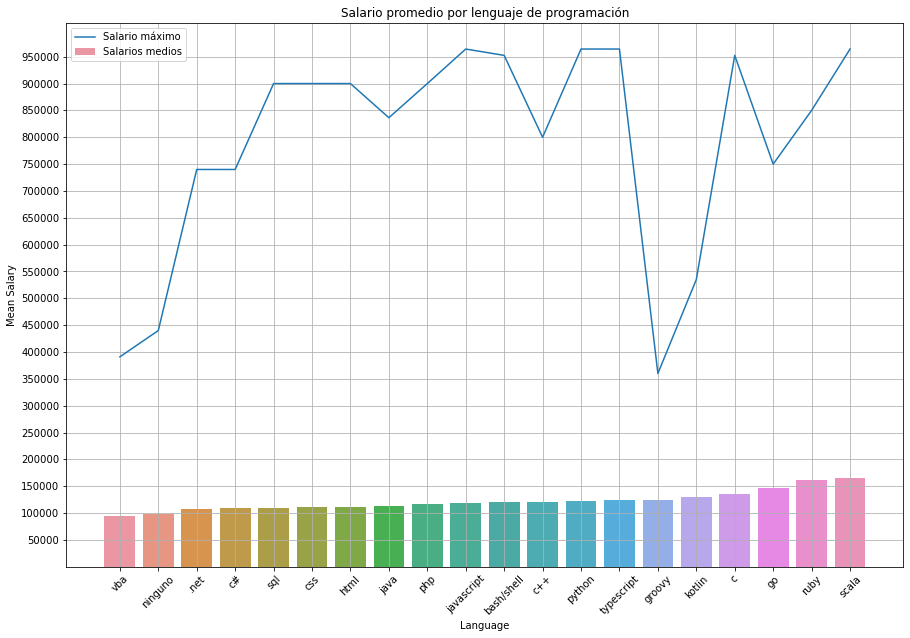

In [190]:
fig = plt.figure(figsize=(15,10))
ax = sns.barplot(x=df_final_metrics.Language, y=df_final_metrics.subpop_Salary_mean, data=df_final_metrics, label='Salarios medios')
ax = sns.lineplot(x=df_final_metrics.Language, y=df_final_metrics.max_salary, data=df_final_metrics, label='Salario máximo')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
y_min = 50000
y_max = 1000000
ticks = range(y_min, y_max, 50000)
plt.yticks(ticks)
plt.ylabel('Mean Salary')
plt.title('Salario promedio por lenguaje de programación')
plt.grid()
leg = ax.legend(loc ="upper left")


Text(0, 0.5, 'Mean Salary')

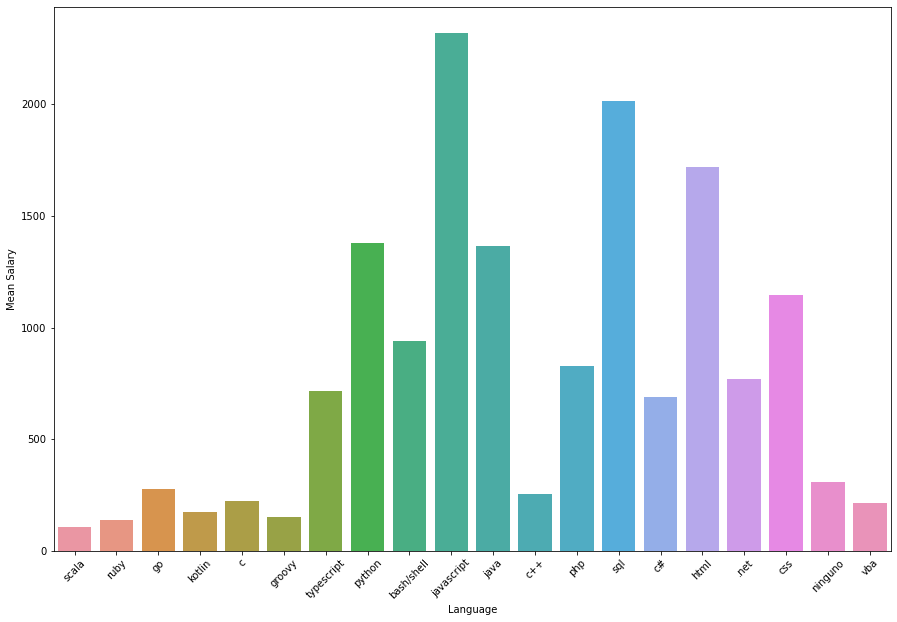

In [64]:
fig = plt.figure(figsize=(15,10))
ax = sns.barplot(x=df_final_metrics.Language, y=df_final_metrics.n_programmers, data=df_final_metrics)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('Mean Salary')

#Respuestas a las preguntas principales:

###1-Que lenguajes ganan más?


> Los 3 lenguajes que mas ganan son ***scala***, ***ruby*** y ***go***. A pesar de ello ***no son los mas populares***. Comparando medias y medianas, son los tres que tienen mas desplazamiento a la derecha, lo cual se interpreta como mas asimetría hacia mejores pagos, talvez asociado a programadores en el mismo lenguage que son mas creativos y puestos de trabajo mas especializados. ***Saber estos lenguages también es lo que dá mayores chances de ganar más que la media de programadores***. Si se analiza el ranking de pagos y el número de programadores, ***no se observa correlación entre paga y popularidad***.



